In [23]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import json

In [24]:
from sklearn.model_selection import train_test_split
import time

from libworm.model.beta_neuron import NeuronNetwork, from_connectome
from libworm.data import connectomes, traces
from libworm import preprocess
from libworm.functions import set_neurons, tcalc_s_inf, set_trace
from libworm.data.neuron import full_sensory_list

from math import tau

In [25]:
def setup(G_syn_value = 100.0, 
            G_gap_value = 100.0,
            G_leak_value = 10.0):
    _, trace, trace_labels, label2index, timestamps = traces.load_trace()
    timestamps = timestamps - timestamps[0]
    
    chemical, gapjn = connectomes.load_cook_connectome()
    neurons = connectomes.get_main_neurons(chemical, gapjn)
    neurons.sort(key=lambda item: f"AAA{label2index[item]:04d}{item}" if item in label2index else item)
    model = from_connectome(chemical,
                            gapjn,
                            neurons,
                            V_value=0.0,
                            G_gap_value=G_gap_value,
                            G_syn_value=G_syn_value,
                            G_leak_value=G_leak_value)
    
    cell = "SMBVR"
    
    not_in_main_section = [label2index[key] for key in label2index if key not in neurons]
    not_labelled = [i for i, _ in enumerate(trace[:, 0]) if i not in label2index.values()]
    
    removal = list(set(not_in_main_section).union(not_labelled))
    
    trace = np.delete(trace, removal, axis=0)
    
    trace_pairs = [(time, trace[:, i]) for i, time in enumerate(timestamps)]

    return model, trace_pairs, neurons

In [26]:
with open("rust/processed_data/default_g_syn.json", "r") as file:
    g_syn = np.array(json.load(file)).reshape(280, 280)

with open("rust/processed_data/default_e_syn.json", "r") as file:
    e_syn = json.load(file)

with open("rust/processed_data/default_g_gap.json", "r") as file:
    g_gap = np.array(json.load(file)).reshape(280, 280)

with open("rust/processed_data/proc_calc_syn_g.json", "r") as file:
    calc = json.load(file)

In [30]:
model, trace, neurons = setup()

<Axes: >

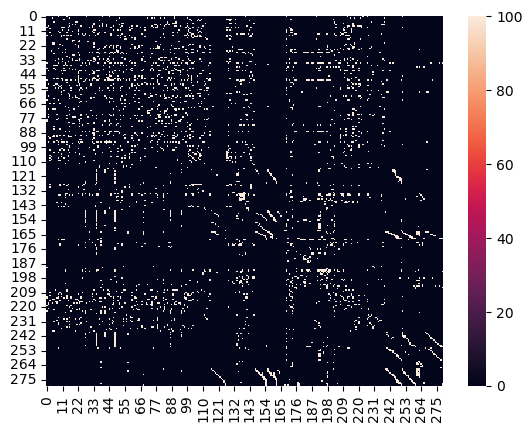

In [31]:
sns.heatmap(g_syn)

<Axes: >

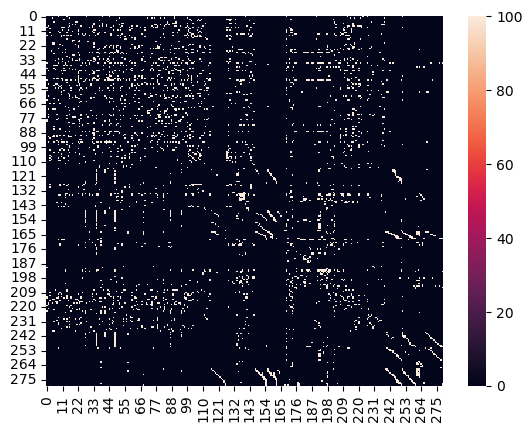

In [32]:
sns.heatmap(model.big_G_syn)

In [33]:
chemical, gapjn = connectomes.load_cook_connectome()

In [34]:
gapjn['CANR']['ALA']

401.0

In [35]:
gap_csv = pd.read_csv("gapjn.csv").fillna(0)
gap_data = gap_csv.values[:, 1:]
gap_labels = gap_csv.values[:, 0]

In [36]:
direct_gap.max()

NameError: name 'direct_gap' is not defined

In [37]:
direct_gap = gap_data.astype(np.float64)

In [38]:
og_order_neurons = [cell for cell in gap_labels if cell in neurons]

In [39]:
recon_gap = np.zeros((len(og_order_neurons), len(og_order_neurons)))

for i, cell_a in enumerate(og_order_neurons):
    for j, cell_b in enumerate(og_order_neurons):
        recon_gap[i, j] = gapjn[cell_a][cell_b]
        

In [40]:
recon_gap.max()

250.0

<Axes: >

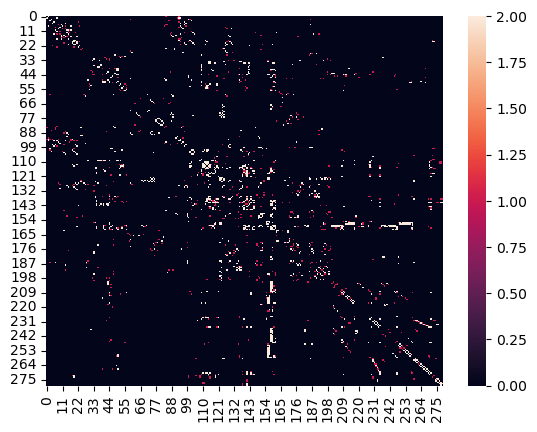

In [41]:
sns.heatmap(recon_gap, vmin=0, vmax=2)

In [42]:
remove_list = [i for i in range(len(gap_labels)) if gap_labels[i] not in neurons]

<Axes: >

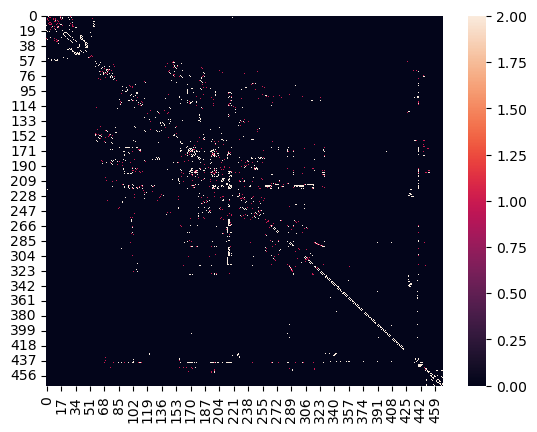

In [43]:
sns.heatmap(direct_gap, vmin=0, vmax=2)

In [44]:
filter_gap = np.delete(direct_gap, remove_list, axis=0)
filter_gap = np.delete(filter_gap, remove_list, axis=1)

<Axes: >

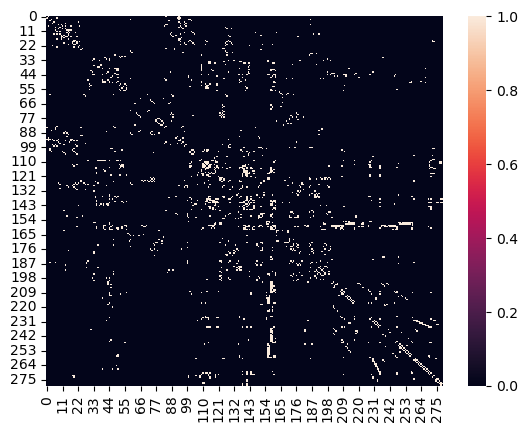

In [69]:
sns.heatmap(recon_gap, vmin=0, vmax=1)

<Axes: >

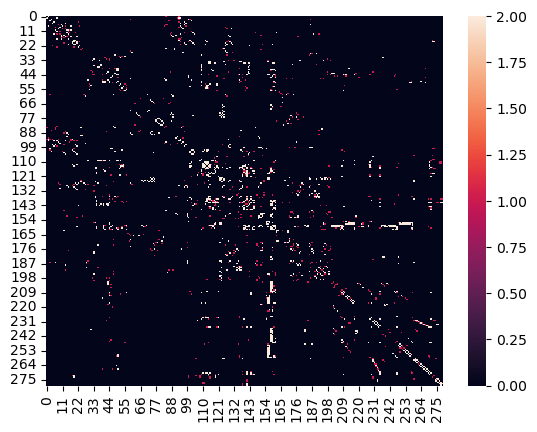

In [46]:
sns.heatmap(filter_gap, vmin=0, vmax=2)

<Axes: >

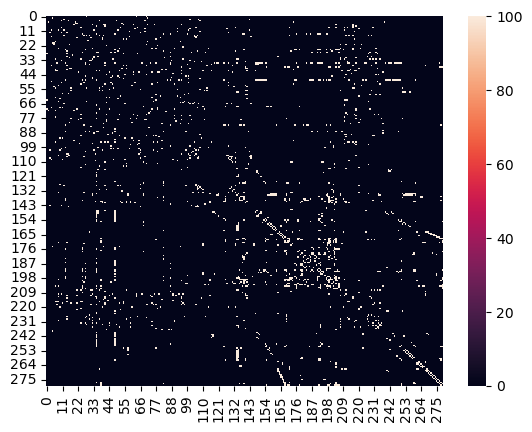

In [47]:
sns.heatmap(g_gap)

In [48]:
chem_csv = pd.read_csv("chemical.csv").fillna(0)
chem_data = chem_csv.values[:, 1:]
chem_labels = chem_csv.values[:, 0]
chem_cols = chem_csv.columns[1:]
direct_chem = chem_data.astype(np.float64)

<Axes: >

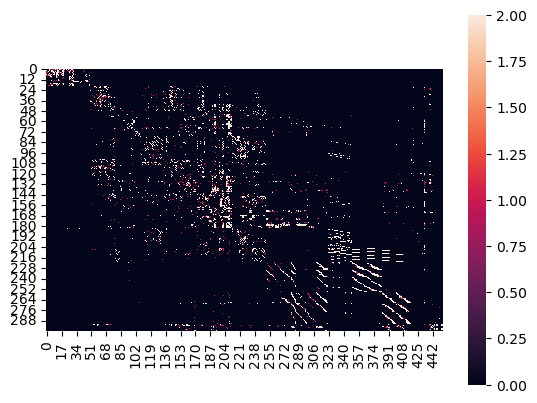

In [49]:
sns.heatmap(direct_chem, vmin=0, vmax=2, square=True)

<Axes: >

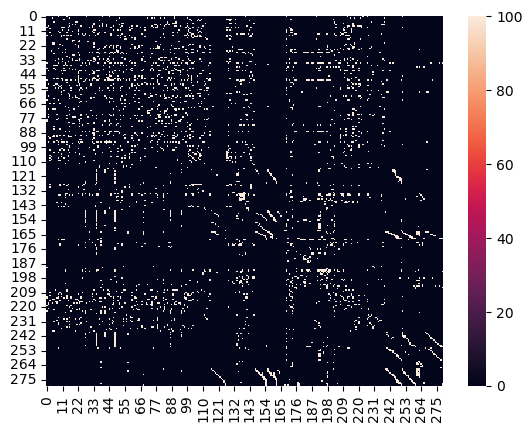

In [50]:
sns.heatmap(g_syn)

<Axes: >

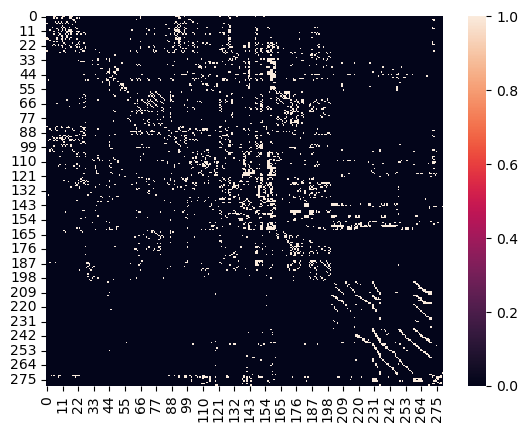

In [68]:
recon_syn = np.zeros((len(og_order_neurons), len(og_order_neurons)))

for i, cell_a in enumerate(og_order_neurons):
    for j, cell_b in enumerate(og_order_neurons):
        recon_syn[i, j] = chemical[cell_a][cell_b]

sns.heatmap(recon_syn, vmin=0, vmax=1)

In [52]:
row_remove = [i for i in range(len(chem_labels)) if chem_labels[i] not in neurons]
col_remove = [i for i in range(len(chem_cols)) if chem_cols[i] not in neurons]

In [53]:
filter_chem = np.delete(direct_chem, row_remove, axis=0)
filter_chem = np.delete(filter_chem, col_remove, axis=1)

In [54]:
filter_chem.shape

(280, 280)

<Axes: >

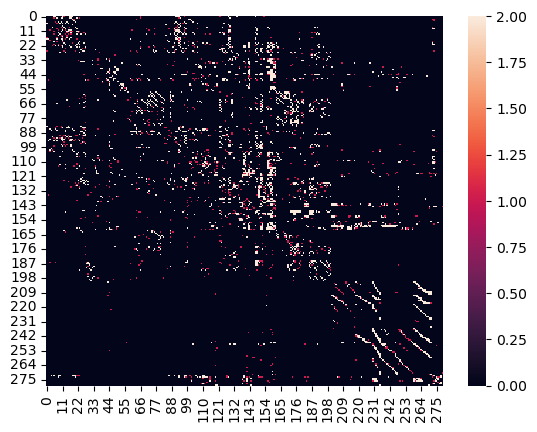

In [55]:
sns.heatmap(filter_chem, vmin=0, vmax=2)

In [56]:
new_csv = pd.read_csv("NeuronConnect.csv")

In [70]:
new_recon_syn = np.zeros((len(og_order_neurons), len(og_order_neurons)))
new_recon_gap = np.zeros((len(og_order_neurons), len(og_order_neurons)))

for i, cell_a in enumerate(og_order_neurons):
    print("#", end='')
    for j, cell_b in enumerate(og_order_neurons):

        neuron_one = new_csv[new_csv['Neuron 1'] == cell_a]
        neuron_both = neuron_one[neuron_one['Neuron 2'] == cell_b]

        for item in neuron_both.values:
            if item[2] == 'EJ':
                new_recon_gap[i, j] = item[3]
            elif 'S' in item[2]:
                new_recon_syn[i, j] = item[3]

########################################################################################################################################################################################################################################################################################

<Axes: >

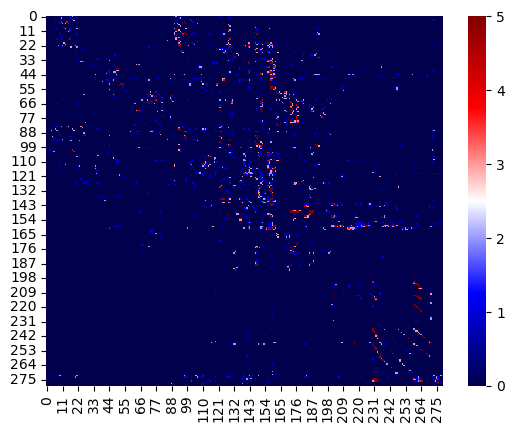

In [76]:
sns.heatmap(new_recon_syn, vmin=0, vmax=5, cmap='seismic')

<Axes: >

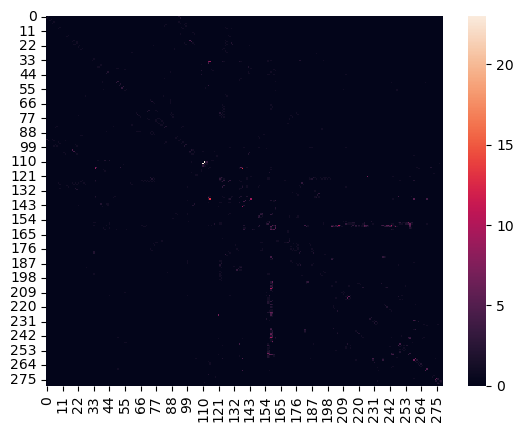

In [79]:
sns.heatmap(new_recon_gap)

In [82]:
with open("rust/processed_data/new_g_syn.json", "w") as file:
    json.dump((new_recon_syn * 100.0).T.flatten().tolist(), file)

In [83]:
with open("rust/processed_data/new_g_gap.json", "w") as file:
    json.dump((new_recon_gap * 100.0).T.flatten().tolist(), file)